<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/hands-on-computer-vision-with-detectron2/05-custom-object-detection/02_default_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Default_Trainer

Detectron2 provides a default trainer class, which helps to train Detectron2 models on custom datasets
conveniently

##Setup

In [1]:
%%capture

!python -m pip install "git+https://github.com/facebookresearch/detectron2.git"
#!sudo apt-get install tree
#!pip install -q pylabel

In [2]:
import detectron2
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator
from detectron2.config import get_cfg
from detectron2 import model_zoo

import os
import pickle
import shutil
import random
import logging
import math
from glob import glob
from tqdm import tqdm
#import yaml
#from yaml.loader import SafeLoader
#from pylabel import importer

import torch
import cv2

import numpy as np
import matplotlib.pyplot as plt

from detectron2.utils.logger import setup_logger

# Suppress some user warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
print(detectron2.__version__)

0.6


In [ ]:
!wget https://github.com/rahiakela/computer-vision-research-and-practice/blob/main/hands-on-computer-vision-with-detectron2/05-custom-object-detection/dataset/braintumors_coco.zip?raw=true -O braintumors_coco.zip
!unzip -q braintumors_coco.zip

In [5]:
# Some configurations
name_ds = "braintumors_coco"
name_ds_train = name_ds + "_train"
name_ds_test = name_ds + "_test"
image_root_train = name_ds + "/train"
image_root_test = name_ds + "/test"
af = "_annotations.coco.json"
json_file_train = name_ds + "/train/" + af
json_file_test = name_ds + "/test/" + af

# Register datasets
## train dataset
register_coco_instances(
    name=name_ds_train,
    metadata={},
    json_file=json_file_train,
    image_root=image_root_train
)
## test dataset
register_coco_instances(
    name=name_ds_test,
    metadata={},
    json_file=json_file_test,
    image_root=image_root_test
)

##Training configuration

In [6]:
# let's prepare a logger that Detectron2 uses to log training/inferencing information
logger = setup_logger()

In [7]:
# getting a training configuration
output_dir = "output/object_detector"
os.makedirs(output_dir, exist_ok=True)

output_cfg_path = os.path.join(output_dir, "cfg.pickle")

nc = 2
device = "cuda"

config_file_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [8]:
# let's create a configuration file
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)

# Download weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)

# Set datasets
cfg.DATASETS.TRAIN = (name_ds_train,)
cfg.DATASETS.TEST = (name_ds_test,)

# Workers
cfg.DATALOADER.NUM_WORKERS = 2

# Images per batch
cfg.SOLVER.IMS_PER_BATCH = 4  # 8

# Learning rate
cfg.SOLVER.BASE_LR = 0.00025

# Iterations
cfg.SOLVER.MAX_ITER  = 5000
cfg.SOLVER.CHECKPOINT_PERIOD  = 500

# Classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc
cfg.MODEL.DEVICE = device

cfg.OUTPUT_DIR = output_dir

In [9]:
# save configuration file for future use
with open(output_cfg_path, "wb") as f:
  pickle.dump(cfg, f, protocol=pickle.HIGHEST_PROTOCOL)

##Model Training

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.train()

In [11]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [12]:
# let's see the log events
!ls -1 {cfg.OUTPUT_DIR}

cfg.pickle
events.out.tfevents.1699944353.6eb31e52ca59.3814.0
last_checkpoint
metrics.json
model_0000499.pth
model_0000999.pth
model_0001499.pth
model_0001999.pth
model_0002499.pth
model_0002999.pth
model_0003499.pth
model_0003999.pth
model_0004499.pth
model_0004999.pth
model_final.pth


##Best model

In [13]:
# let's lists all the models saved at every checkpoint period over the training process
model_names = []
max_iter = cfg.SOLVER.MAX_ITER
checkpoint = cfg.SOLVER.CHECKPOINT_PERIOD

for i in range(1, max_iter//checkpoint):
  model_names.append(f"model_{str(i * checkpoint - 1).zfill(7)}.pth")
model_names.append("model_final.pth")
print(model_names)

['model_0000499.pth', 'model_0000999.pth', 'model_0001499.pth', 'model_0001999.pth', 'model_0002499.pth', 'model_0002999.pth', 'model_0003499.pth', 'model_0003999.pth', 'model_0004499.pth', 'model_final.pth']


In [14]:
# let's prepares an evaluator to evaluate how each of these models performs
evaluator = COCOEvaluator(
    dataset_name=name_ds_test,
    tasks=("bbox",),
    distributed=False,
    output_dir=os.path.join(output_dir, "test_results")
)

In [15]:
# let's performs the evaluations on each of the generated models
logger.setLevel(logging.CRITICAL)
model_eval_results = []

for model_name in model_names:
  # load weights
  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_name)
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
  # predictor
  predictor = DefaultPredictor(cfg)
  # evaluate
  x = trainer.test(cfg, predictor.model, evaluators=[evaluator])
  model_eval_results.append(x["bbox"])

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.096
 Average Recall     (AR) @[ IoU=0.50:0.

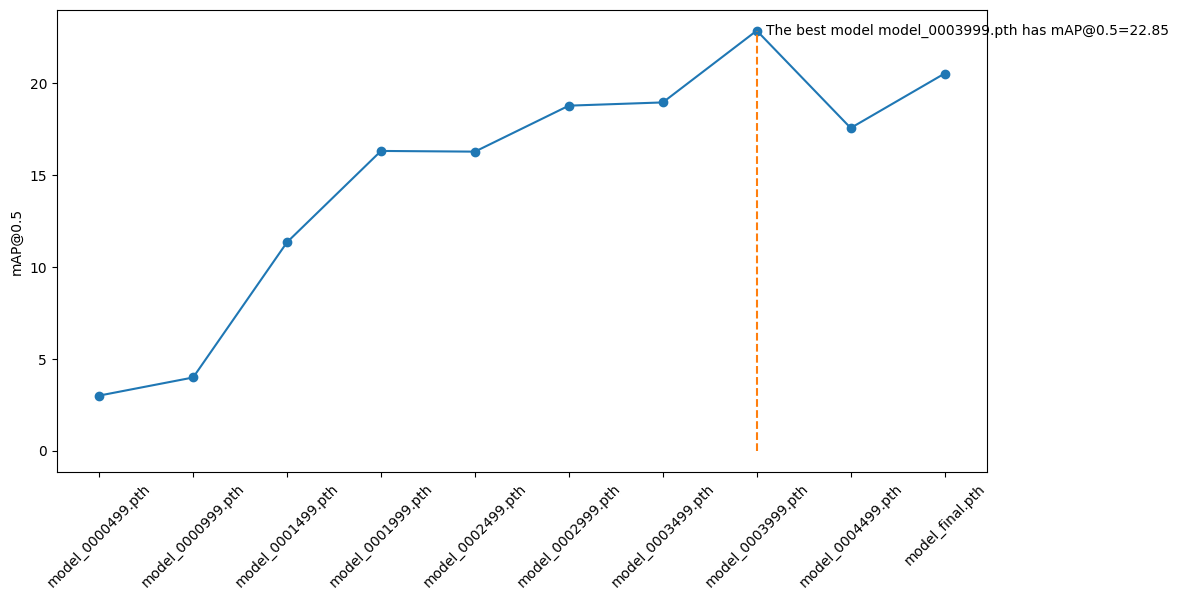

In [16]:
# let's extracts these values for all models, gets the best one, and plots these values
aps = [x["AP50"] if not math.isnan(x["AP50"]) else 0 for x in model_eval_results]
best_model_idx = np.argmax(aps)
best_model_name = model_names[best_model_idx]
best_ap = aps[best_model_idx]
anno_text = f"The best model {best_model_name} has mAP@0.5={round(best_ap, 2)}"

plt.figure(figsize=(12, 6))
x = [i for i in range(len(aps))]
y = aps
plt.xticks(ticks=x, labels=model_names, rotation=45)
plt.plot(x, y)
plt.scatter(x, y)
plt.plot([best_model_idx, best_model_idx], [0, best_ap], "--")
plt.ylabel("mAP@0.5")
plt.text(best_model_idx + 0.1, best_ap, anno_text, ha="left", va="center")
plt.show()

##Confidence threshold

In [18]:
thresh_tests = [0.1 * i for i in range(10)]
thresh_eval_results = []

for thresh_test in thresh_tests:
  # load weights
  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, best_model_name)
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = thresh_test

  # predictor
  predictor = DefaultPredictor(cfg)

  # evaluate
  x = trainer.test(cfg, predictor.model, evaluators=[evaluator])
  thresh_eval_results.append(x["bbox"])

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.230
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.

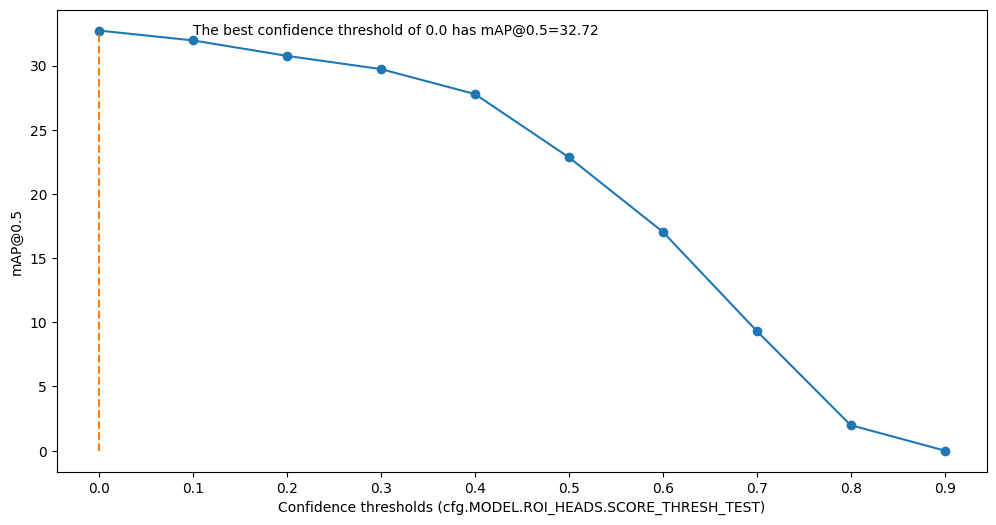

In [19]:
# let's extracts these values for all models, gets the best one, and plots these values
aps = [x["AP50"] if not math.isnan(x["AP50"]) else 0 for x in thresh_eval_results]
best_thresh_idx = np.argmax(aps)
best_thresh_name = thresh_tests[best_thresh_idx]
best_ap = aps[best_thresh_idx]
anno_text = f"The best confidence threshold of {best_thresh_name} has mAP@0.5={round(best_ap, 2)}"

plt.figure(figsize=(12, 6))
x = [round(x, 2) for x in thresh_tests]
y = aps
plt.plot(x, y)
plt.scatter(x, y)
plt.xticks(ticks=thresh_tests, labels=x)
plt.plot([best_thresh_name, best_thresh_name], [0, best_ap], "--")
plt.xlabel("Confidence thresholds (cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)")
plt.ylabel("mAP@0.5")
plt.text(best_thresh_name + 0.1, best_ap, anno_text, ha="left", va="center")
plt.show()

##Displaying Samples

In [20]:
random.seed(42)

def plot_random_samples(name_ds, n=3, predictor=None):
  # access
  dataset = DatasetCatalog.get(name_ds)
  metadata = MetadataCatalog.get(name_ds)
  # plot (arrange in 3x3)
  nrows = int(-(-n/3)) # ceil
  ncols = 3
  samples = random.sample(dataset, n)
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(21, 7))
  for i,s in enumerate(samples):
    ax = axs[i//ncols][i%ncols] if len(axs.shape) == 2 else axs[i]
    img = cv2.imread(s["file_name"])
    v = Visualizer(img[:,:, ::-1], metadata=metadata, scale=0.5)
    # visualize ground-truths
    v = v.draw_dataset_dict(s)
    ax.imshow(v.get_image())
    ax.axis("off")
  plt.tight_layout()
  plt.show()

  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(21, 7))
  for i,s in enumerate(samples):
    ax = axs[i//ncols][i%ncols] if len(axs.shape) == 2 else axs[i]
    img = cv2.imread(s["file_name"])
    # predict
    outputs = predictor(img)
    # visualize prediction results
    v = Visualizer(img[:,:, ::-1], metadata=metadata, scale=0.5)
    # visualize ground-truths
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    ax.imshow(v.get_image())
    ax.axis("off")
  plt.tight_layout()
  plt.show()

In [21]:
# best model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, best_model_name)
predictor = DefaultPredictor(cfg)

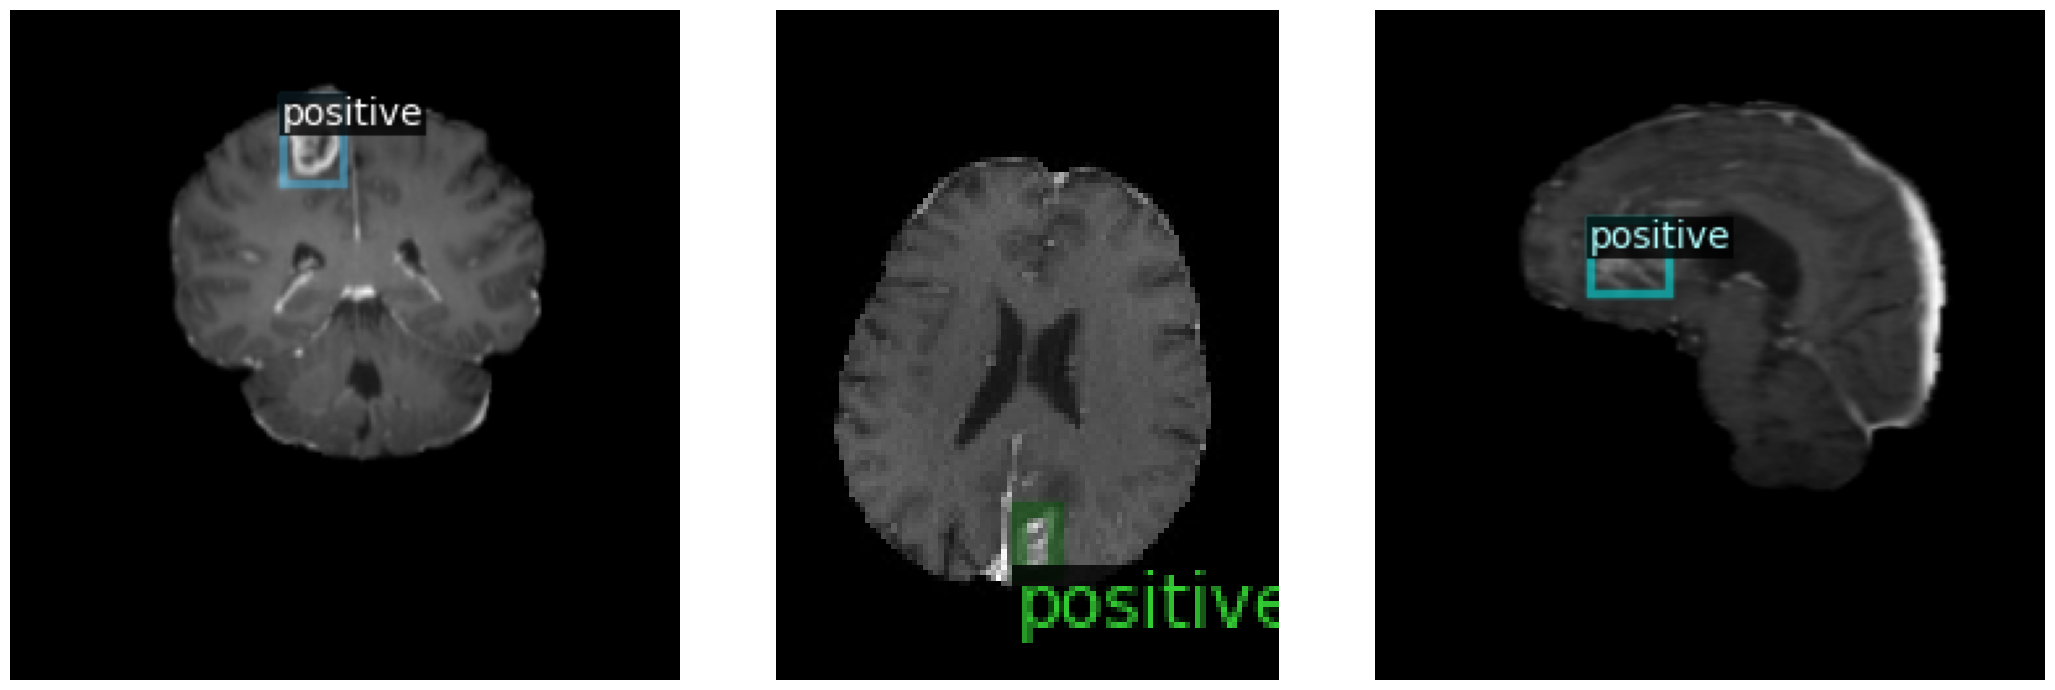

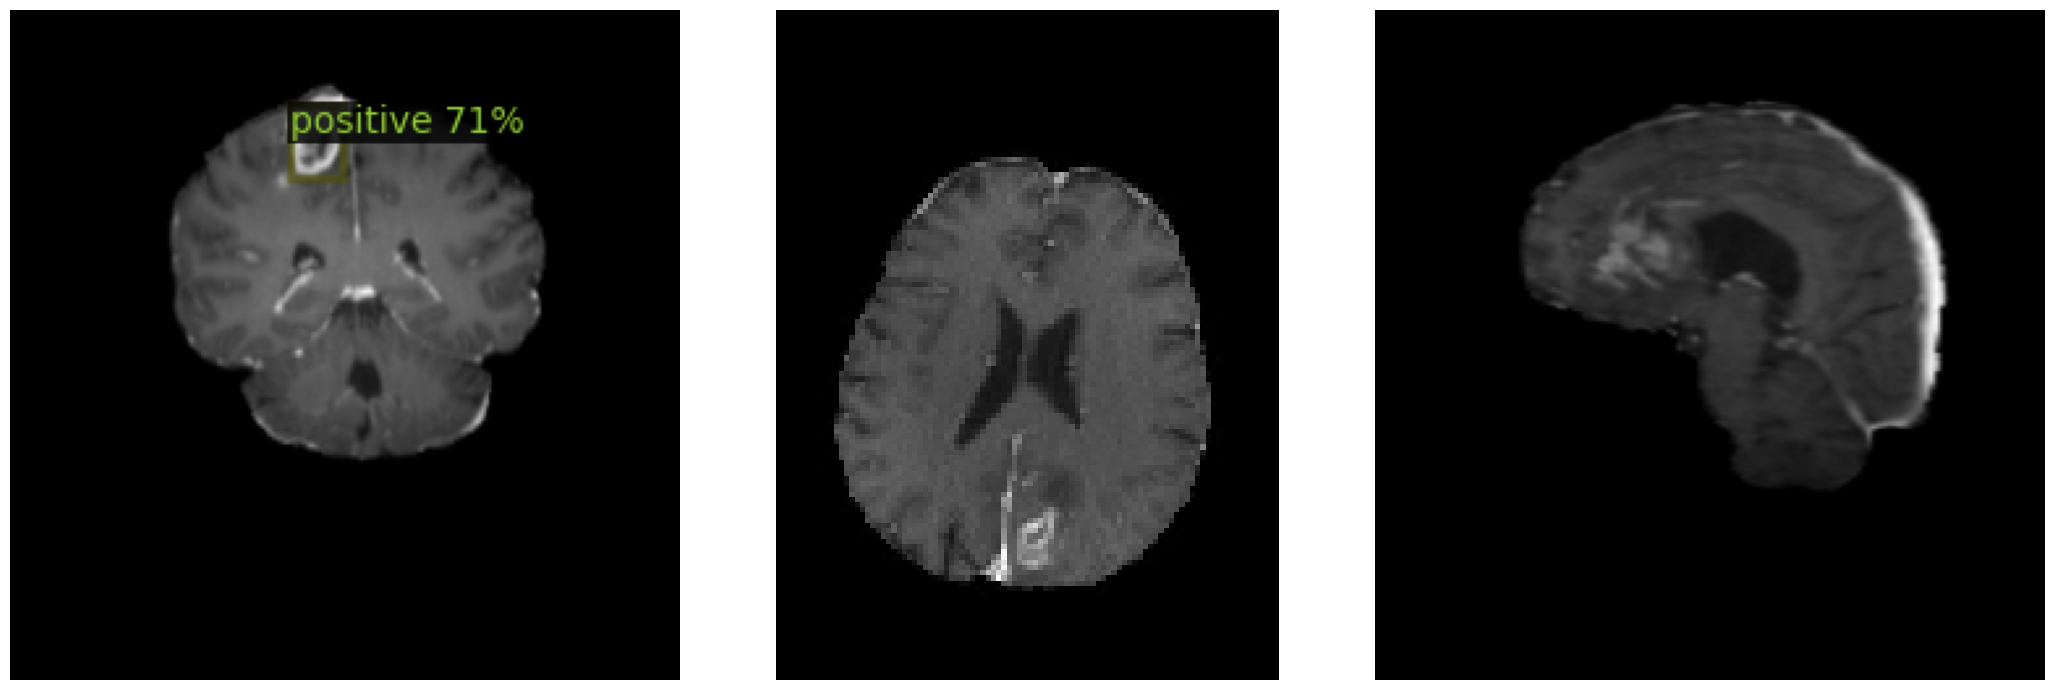

In [22]:
# let's randomly sample images and visualize the ground-truth labels and the predicted results
plot_random_samples(name_ds_train, predictor=predictor)

Training models using the Detectron2 default trainer (`DefaultTrainer`) is convenient and can satisfy most common needs. However, in several cases, we may need to develop a custom trainer to facilitate training and analyze the training metrics and results.